# Understanding and accessing LINEAR and ZTF data

This notebook contains all the information necessary to understand the data, its descriptive statistics, and how to plot light curves.

In [1]:
# importing all of the necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sc
import random
import pickle

from matplotlib import pyplot as plt
from scipy.stats import norm

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

from ztfquery import lightcurve
from matplotlib import ticker
import dask.dataframe as dd 
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import threading
import os

np.random.seed(42)
%matplotlib inline  

In [2]:
sns.set_theme() # setting the theme for plotting

In [3]:
import sys
sys.path.insert(0,'../src/')
sys.path
from ZTF_data import data_ztf
from descriptive_stats import*
from plotting import*
from config import*

Loading the data!
Loading the data!


# LINEAR data

### A bit about LINEAR

The LINEAR dataset (Lincon Near-Earth Asteroid Research) contains 7010 light curves of periodic variable stars. While the original mission of this survey was to find asteroids, it subsequently monitored a substantial portion of the sky, cataloging the brightness of various variable stars. This survey was operated with two telescopes on a site in New Mexico. The two telescopes are equatorially mounted of GEODSS type, where each telescope is denoted as L1 and L2. They observed a broad part of the visible spectrum and the near-infrared spectrum. 

The preprocessing process contained the following procedures:
1. Bias correction: removing noise created by the camera
2. Flat-field correction: removing artificial lines and gradients due to varying sensitivities of pixels
3. Preliminary fixed-aperture photometry: subtracting the background light using Poisson statistics

After preprocessing, the data had to be astrometrically recalibrated, meaning that the scientists had to ensure the coordinates of the objects in the data matched another survey, like SDSS. Of all the data, 7% had bad astrometry (the coordinates did not fit), so the scientists removed them from the dataset. The rest of the data had a 1-2% error in astrometry.

Next up was photometric recalibration, meaning that the filters and fluxes had to be recalibrated to match SDSS data. The corrections regarded CCD camera errors, correcting the magnitudes of objects in the data, and correcting underestimated magnitude errors. After the photometric recalibration, the data were grouped into various categories, including a variable star category. While the original dataset has 5 billion objects, only 7010 are confirmed periodic variable stars. The scientists subsequently analyzed this portion of the dataset by categorizing the light curves, calculating their periods, and inferring conclusions from the preceding factors. 

## Downloading LINEAR data

Downloading the data requires one line of code since we are downloading the data from the AstroML library.

In [4]:
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

We are accessing the data through the `AstroML` library since the library's creators have already organized and prepared the data.

In [5]:
# acessing all of the light curves from the data and checking if any light curve is missing
c = 0 
for i in data.ids: # iterating through all of the data ID's
    light_curve = data.get_light_curve(i) # fetching the light curve data for a specific ID
    c += 1 
    print(light_curve[:1]) # printing the first row of the light curve
print(c) 

[[5.26514326e+04 1.57560000e+01 3.50000000e-02]]
[[5.26524776e+04 1.65340000e+01 5.90000000e-02]]
[[5.26374598e+04 1.54500000e+01 4.48000000e-01]]
[[5.26524564e+04 1.48020000e+01 1.10000000e-02]]
[[5.2652457e+04 1.3849000e+01 6.0000000e-03]]
[[5.26524571e+04 1.57110000e+01 2.60000000e-02]]
[[5.26644199e+04 1.60240000e+01 8.90000000e-02]]
[[5.26534613e+04 1.54790000e+01 2.00000000e-02]]
[[5.26534613e+04 1.50940000e+01 1.30000000e-02]]
[[5.26534612e+04 1.57050000e+01 2.40000000e-02]]
[[5.26534612e+04 1.60910000e+01 3.50000000e-02]]
[[5.26534609e+04 1.51110000e+01 1.70000000e-02]]
[[5.26534617e+04 1.69120000e+01 6.70000000e-02]]
[[5.26534608e+04 1.53420000e+01 1.70000000e-02]]
[[5.26534607e+04 1.50940000e+01 1.30000000e-02]]
[[5.26534608e+04 1.57890000e+01 2.80000000e-02]]
[[5.26134521e+04 1.67090000e+01 7.80000000e-02]]
[[5.26134521e+04 1.61110000e+01 4.40000000e-02]]
[[5.26675229e+04 1.65260000e+01 8.40000000e-02]]
[[5.26464943e+04 1.74710000e+01 1.58000000e-01]]
[[5.2646479e+04 1.54980

The counter has printed the number `7010`, the correct amount of light curves in this dataset. No light curves are missing!

Our data contains three columns: `time`, `magnitude`, and `magnitude_error`.

## Introductory information about LINEAR data

Before we begin the statistical data analysis of light curves, we must look into the measurements themselves. In this section, we will analyze the periods of observation of each star, the number of observations, and the distribution of observations.

In [6]:
# counting the number of measurements of each light curve
p = []
for i in data.ids:
    lc = data.get_light_curve(i)
    t, m, me = lc.T
    p.append(len(t))

In [7]:
total_obser = sum(p) # summing the number of measurements of every light curve
print(total_obser)

1851936


Our dataset contains 1 851 936 observations!

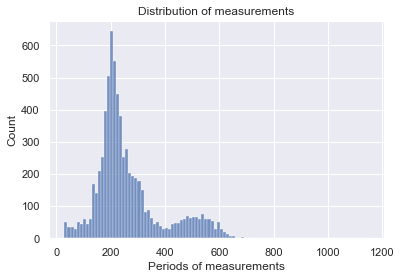

In [8]:
sns.histplot(data=p,bins=100) # drawing a histogram of the distribution of measurements
plt.title('Distribution of measurements')
plt.xlabel('Periods of measurements')
plt.show()

The graph above shows that most of our light curves have around 200 to 300 measurements, with a subsequent peak at about 500 measurements per light curve.

In [9]:
# calculating the actual time difference between the first and last observation

tm = []
for i in data.ids:
    lightc = data.get_light_curve(i)
    t, m, me = lightc.T
    time = t[len(t)-1] - t[0] # last time - first time
    tm.append(time)

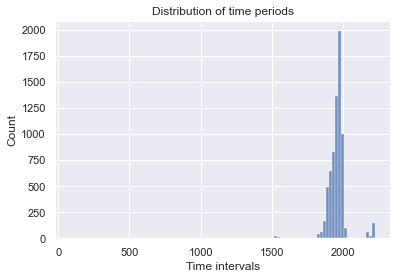

In [10]:
sns.histplot(data=tm,bins=100)
plt.title('Distribution of time periods')
plt.xlabel('Time intervals')
plt.show()

This graph shows that most of our time intervals span around 1800 to 2000 days. So, no matter the variable star type, most actual time intervals are very long.

In [11]:
# the mean difference between two observations/measurements
time_diff = []
for i in data.ids:
    # for every light curve get the data
    lc = data.get_light_curve(i)
    t, m, me = lc.T
    j=0
    tm = []
    while j<len(t): # while our counter is less than the amount of measurements in the light curve
        diff = t[j+1] - t[j] # calculate the difference in time
        tm.append(diff)
        j += 1 # update counter
        
        # define a the last case: if we are at the last element, make sure that we do not go further!
        if j==len(t)-1:
            j=len(t)+1
    time_diff.append((sum(tm)/len(tm))) # calculating the average


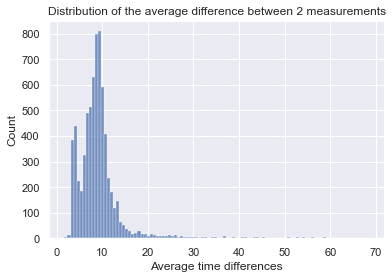

In [12]:
sns.histplot(data=time_diff,bins=100)
plt.title('Distribution of the average difference between 2 measurements')
plt.xlabel('Average time differences')
plt.show()

From the graph above, we can see that most of our light curves have an average of 10 days between 2 measurements; however, a large amount also has an average difference of around 4 to 5 days. However, it is worth keeping in mind that there are substantial gaps in measurements during these light curves, which **highly influence the average**, making it much larger than it really is. 

In [13]:
# median time difference between 2 measurements per light curve
time_diff = []
for i in data.ids:
    lc = data.get_light_curve(i)
    t, m, me = lc.T
    j=0
    tm = []
    while j<len(t):
        diff = t[j+1] - t[j]
        tm.append(diff)
        j += 1
        if j==len(t)-1:
            j=len(t)+1
    time_diff.append(np.median(tm))


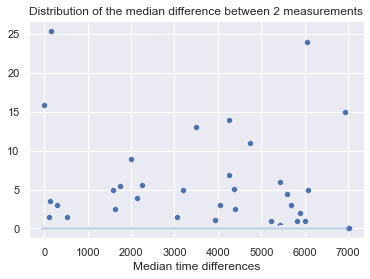

In [14]:
sns.scatterplot(data=time_diff)
plt.title('Distribution of the median difference between 2 measurements')
plt.xlabel('Median time differences')
plt.show()

Calculating the median would be a more appropriate metric because of the reason mentioned in the last paragraph. The graph above shows that **almost all of our measurements, save for a few, have a median value of around 0.** None of the values are 0; however, when rounded up, the difference between the two measurements is a minimal change. The bottom "line" represents the proportion of values whose median is 0 and the rest of the dots which are not 0. 

# Descriptive statistics of LINEAR light curves

This section is dedicated to the **descriptive statistics** of the light curves for `LINEAR` data. We are considering the `magnitude` values and `magnitude_error` values. The quantities are the `mean`, `median`, `standard deviation`, `minimum`, `maximum`, `skewness`, `kurtosis` and `amplitude`.

### Creating a descriptive statistics table for LINEAR Magnitude values

In [15]:
descriptive_stats_mag = lc_descriptive_stats_table_LINEAR('mag')
descriptive_stats_mag

Argument received: mag


,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
10003298,15.920224,15.8880,0.159858,15.679,16.360,0.659768,-0.482567,0.681
10004892,16.839543,16.8440,0.236847,16.382,17.975,0.767109,3.528837,1.593
10013411,15.574235,15.5020,0.192148,15.400,16.391,2.227095,4.286783,0.991
10021274,14.939383,14.9885,0.231373,14.289,15.330,-0.624265,-0.566168,1.041
10022663,14.253744,14.2935,0.227889,13.698,14.665,-0.550420,-0.498097,0.967
...,...,...,...,...,...,...,...,...
9983476,16.105178,16.2230,0.269350,15.256,16.447,-1.299098,0.957857,1.191
9983939,15.392084,15.3705,0.146921,15.021,15.666,0.001482,-0.838033,0.645
9984569,16.878944,16.8865,0.185500,16.015,17.461,-0.272009,0.448430,1.446


In [49]:
descriptive_stats_mag.to_csv('../outputs/descriptive_mag_LINEAR.csv', index=False)

#### Creating a descriptive statistics table for LINEAR Error values

In [16]:
descriptive_stats_error = lc_descriptive_stats_table_LINEAR('magerr')
descriptive_stats_error

Argument received: magerr


,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
10003298,0.048587,0.0440,0.018496,0.018,0.115,1.239252,1.627132,0.097
10004892,0.109491,0.0980,0.053818,0.039,0.332,1.606721,3.142803,0.293
10013411,0.039447,0.0280,0.042827,0.015,0.448,6.871714,56.888840,0.433
10021274,0.020528,0.0200,0.009136,0.009,0.056,1.671405,3.435779,0.047
10022663,0.012114,0.0110,0.005738,0.006,0.043,2.365310,8.099770,0.037
...,...,...,...,...,...,...,...,...
9983476,0.050059,0.0470,0.022007,0.018,0.170,1.708778,4.963436,0.152
9983939,0.026773,0.0240,0.014607,0.011,0.196,6.996748,72.122555,0.185
9984569,0.098475,0.0910,0.044793,0.041,0.554,3.751263,26.878901,0.513


## Analyzing descriptive statistics of LINEAR light curves

### Analysis of LINEAR magnitude values

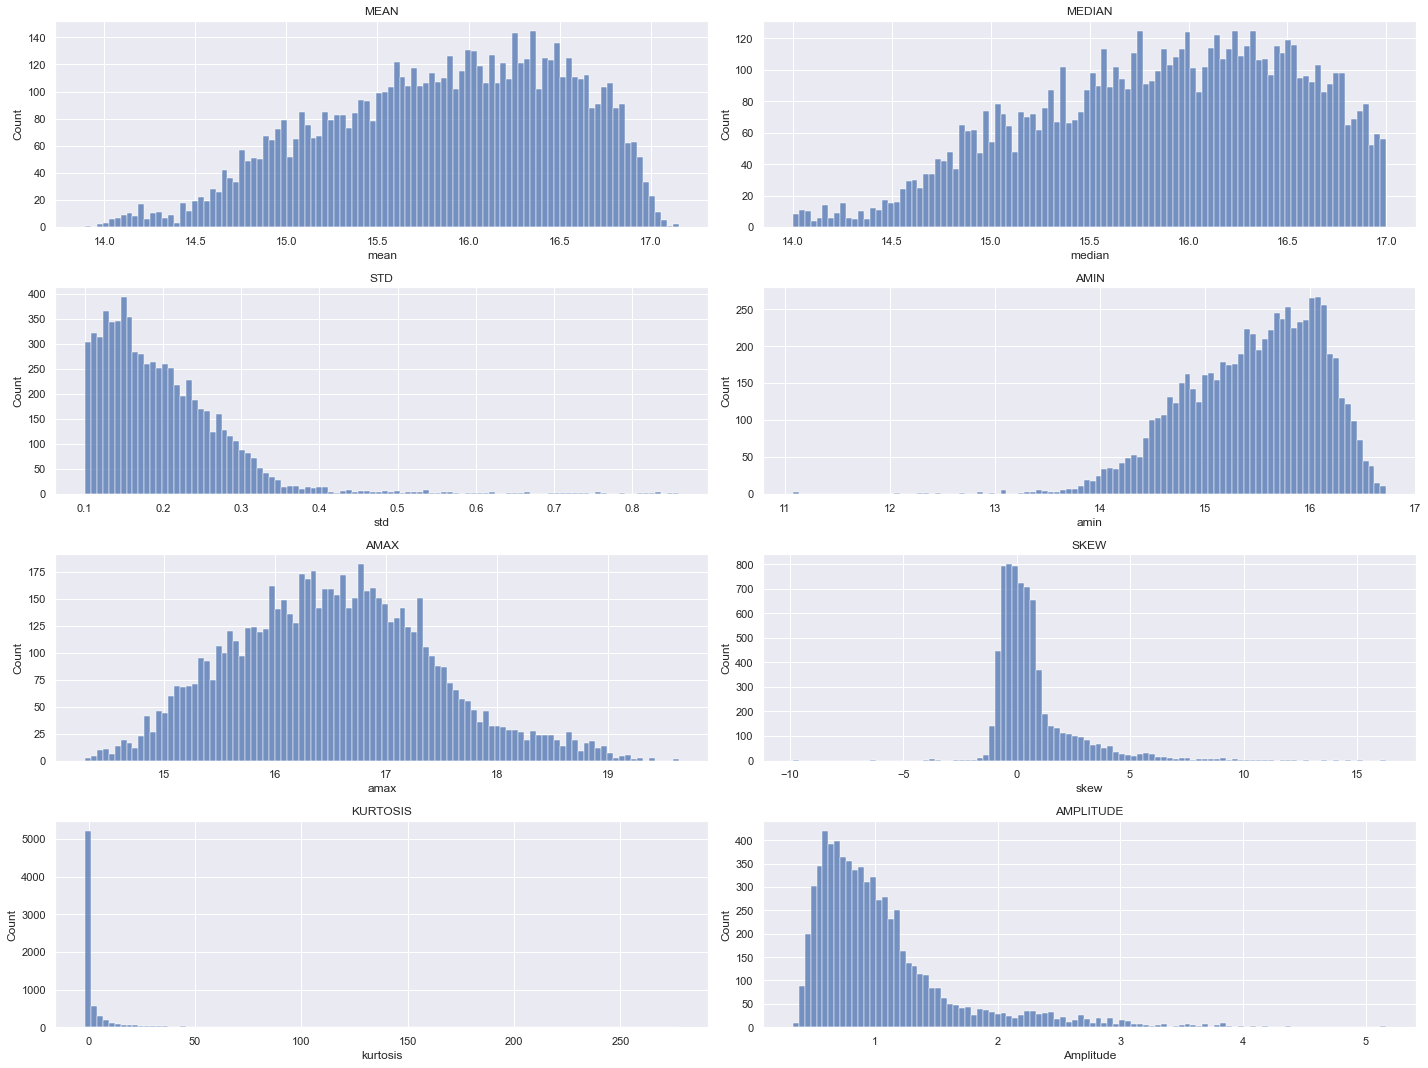

In [17]:
plotting_descriptive_stats(descriptive_stats_mag, 150)

From the graphs above, we can make a few observations.
1. **The mean graph:** is skewed towards the left, where most light curves have a mean of 16 to 16.5 magnitudes.
2. **The median graph:** is also skewed towards the left, where most light curves have a median of around 16 to 16.5 magnitudes, the same as the mean, meaning that outliers do not heavily influence the mean.
3. **The standard deviation graph:** is heavily skewed towards the right, where most light curves have a standard deviation of around 0.1 to 0.2. Since the standard deviation is so small, most of our data is concentrated around the mean of 16-16.5 magnitudes. 
4. **The minimum graph:** values are skewed towards the left, where most light curves have a minimum of around 16 magnitudes. Since the minimum of a light curve is so close to the mean, most of our amplitudes are likely small, as shown in the final graph.
5. **The maximum graph:** values are centered, ranging from 16.5 to 17.5. As with the observation from the previous graph, we can see that most deals are very close to the mean, indicating a small amplitude.
6. **The skewness graph:** Most light curves fall from -0.5 to 0.5, meaning they are almost normally distributed or symmetrical. However, many light curves are also outside of this range, from -1 to 1, meaning they are slightly skewed or asymmetrical. A minimal amount of light curves are very asymmetrical.
7. **The kurtosis graph:** is heavily skewed to the right, where many light curves have a value of around 0, meaning that most of our light curves are close to the normal distribution. However, many light curves are more peaked than the normal distribution since kurtosis values are positive. 
8. **The amplitude graph:** We can see that it is skewed towards the right. Most light curves have an amplitude from approximately 0.4 to 1.3. Our dataset contains few long-period variables since they have a more significant magnitude change, indicating that no cataclysmic variables are present since no amplitude is greater than five magnitudes. 

## Plotting a few distributions of LINEAR light curves

We are plotting the magnitude distribution of a few light curves to visualize the effect of the parameters on actual samples of the data.

In [18]:
listi = [ random.choice(data.ids) for i in range(6)] # making a list of 6 random ID's
listi

[3044799, 13201200, 8373230, 1876472, 10392533, 23864050]

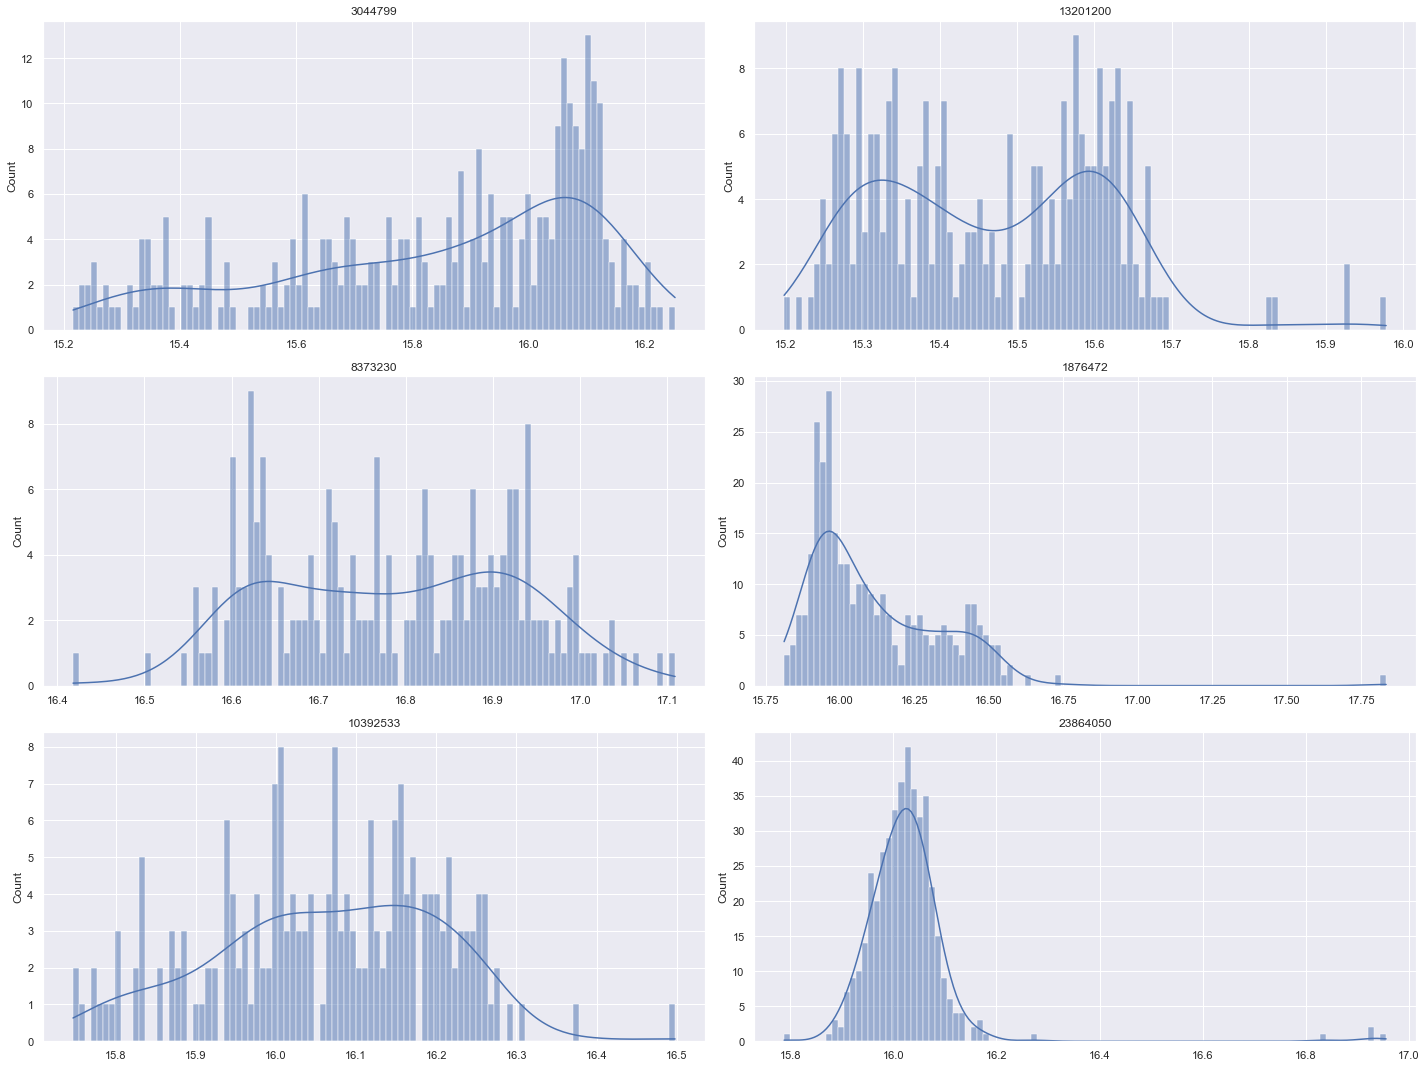

In [19]:
fig, ax = plt.subplots(3,2, figsize=(20,15)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes
for i in range(6): #plot the same type of graph for every property
    lc = data.get_light_curve(listi[i])
    ax[i].set_title(listi[i])
    sns.histplot(data=lc.T[1],bins=100,ax=ax[i], kde=True)
plt.tight_layout()
plt.show()

From the graphs above, we can see just how varied every light curve is. There are no perfect normal distributions in this sample, and we can see how each light curve is skewed and centered differently. 

### Correlations between LINEAR parameters

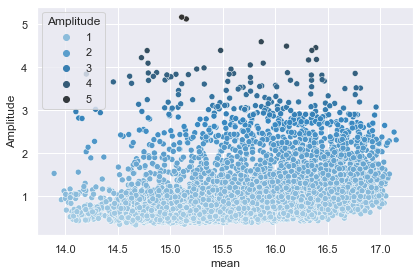

In [20]:
plotting_correlations(descriptive_stats_mag, 'mean', 'Amplitude', 'Amplitude', 'Blues_d')

From the graph above, we can see no correlation between the mean and the amplitude. Near the end, there is a slight increase in amplitude as the mean grows, but this is very small compared to the rest of the dataset. 

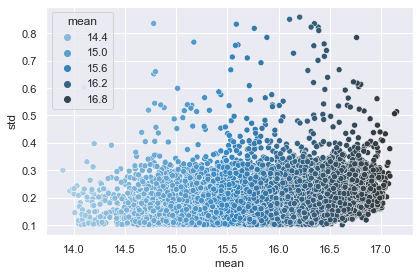

In [21]:
plotting_correlations(descriptive_stats_mag, 'mean', 'std', 'mean', 'Blues_d')

In the graph above, we compare the mean and the standard deviation. Here we also see no correlation. As the mean increases, the standard deviation stays mostly the same, with a few points with higher values.

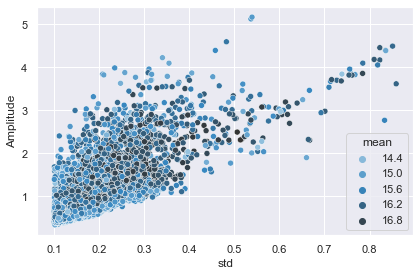

In [22]:
plotting_correlations(descriptive_stats_mag, 'std', 'Amplitude', 'mean', 'Blues_d')

However, in the graph above, we notice an interesting observation. As the standard deviation increases or the distribution becomes more spread out, the amplitude of the light curves also increases, especially after the standard deviation reaches the value of 0.6. 

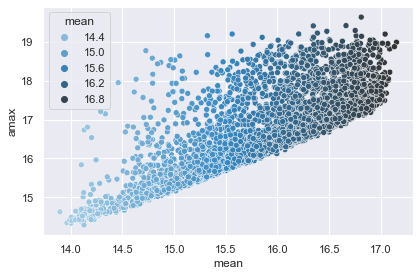

In [23]:
plotting_correlations(descriptive_stats_mag, 'mean', 'amax', 'mean', 'Blues_d')

We also notice an interesting observation from the graph. As the mean increases, the maximum value of the light curve also increases. While this makes intuitive sense, it is helpful to visualize it. 

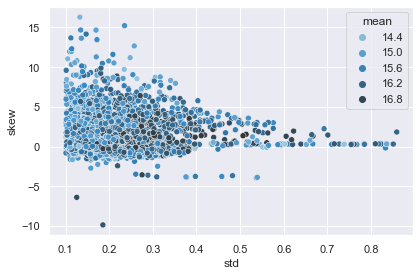

In [24]:
plotting_correlations(descriptive_stats_mag, 'std', 'skew', 'mean', 'Blues_d')

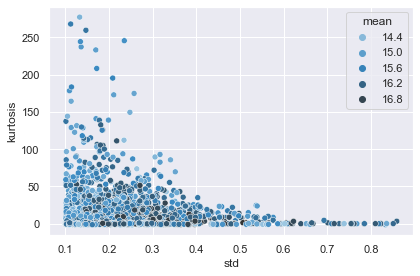

In [25]:
plotting_correlations(descriptive_stats_mag, 'std', 'kurtosis', 'mean', 'Blues_d')

The above two graphs show that both skewness and kurtosis decrease as the standard deviation increases, so as the standard deviation increases that the graph becomes more symmetric and more spread out. 

## Analysis of LINEAR error values

After analyzing the magnitude values of the dataset, it is time to look more closely at the errors in the dataset. 

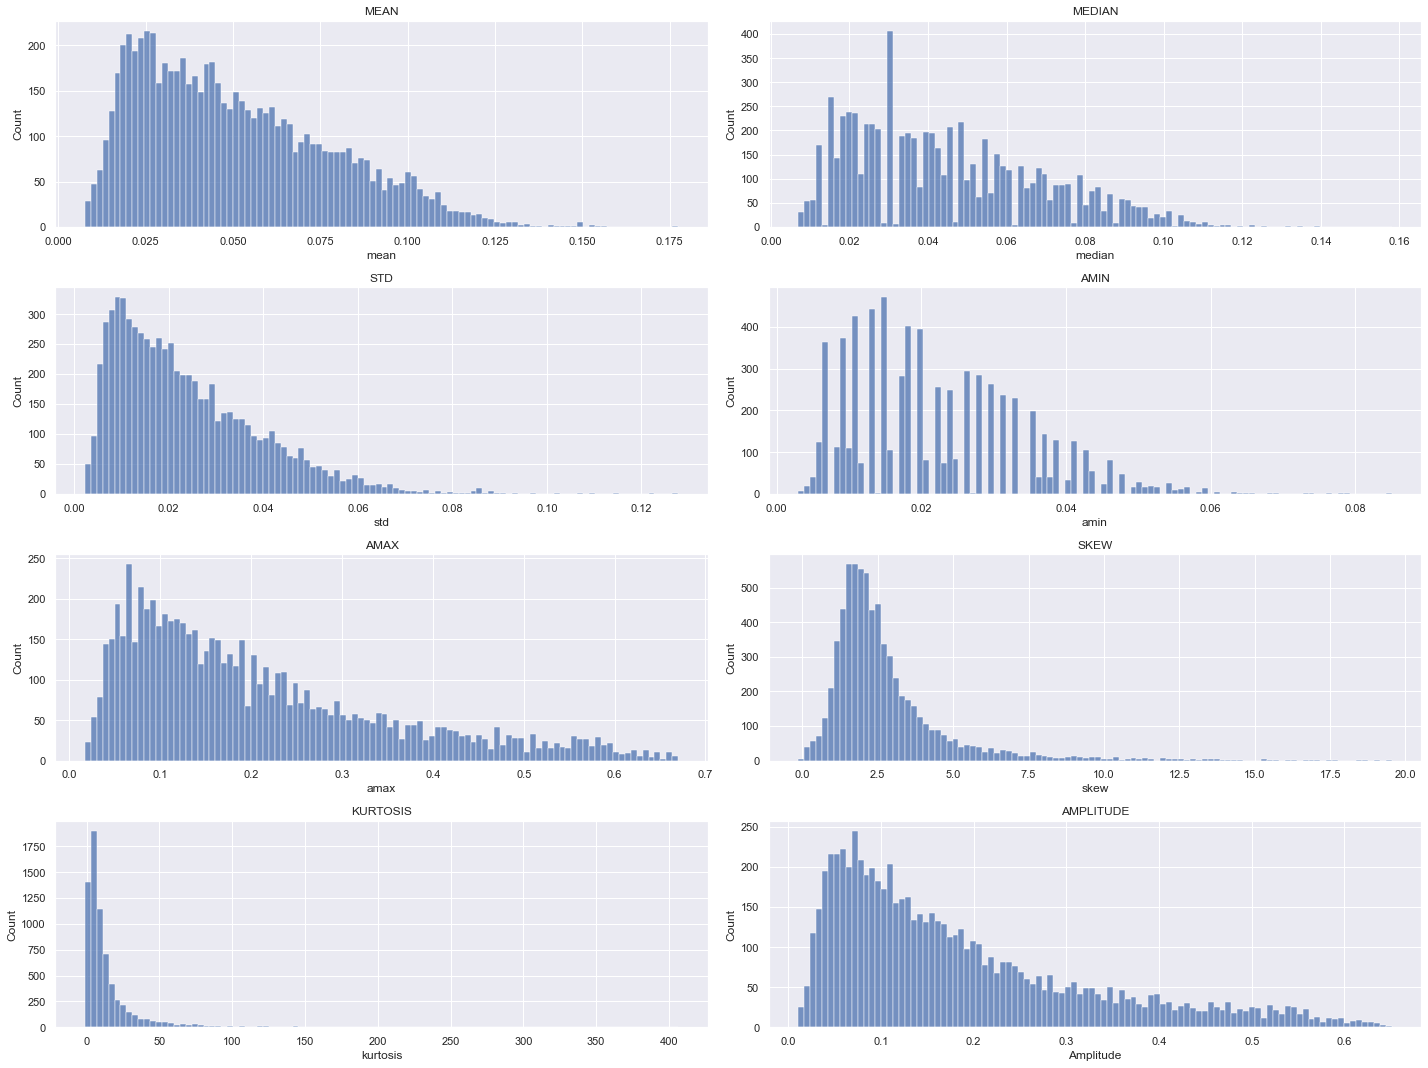

In [26]:
plotting_descriptive_stats(descriptive_stats_error, 150)

From the graphs above, we can see that all of them are skewed towards the right and that:
1. **Mean graph:** Most light curves have a mean of around 0.025.
2. **Median graph:** Most light curves have a median of around 0.02 to 0.04, meaning that the errors are not very variable, and there are no significant outliers.
3. **Standard deviation graph:** Most values of the standard deviation range from 0 to 0.02, meaning that the data is very concentrated around the mean. 
4. **Minimum graph:** Most light curves have a minimum within the range of 0 to 0.02.
5. **Mazimum graph:** Most values range from 0.05 to 0.2, suggesting minor errors!
6. **Skewness graph:** We can see that the most common value is around 2.5, implying heavy asymmetrically. 
7. **Kurtosis graph:** Most values are 0, meaning the distribution is normally peaked. 
8. **Amplitude graph:** We see that most amplitudes of errors, or the difference between the lowest and highest error, are very small, which is great for later data analysis.

## Plotting LINEAR light curves

After understanding the descriptive statistics of the data, its time to look at how the data looks like in the form of light curves. 

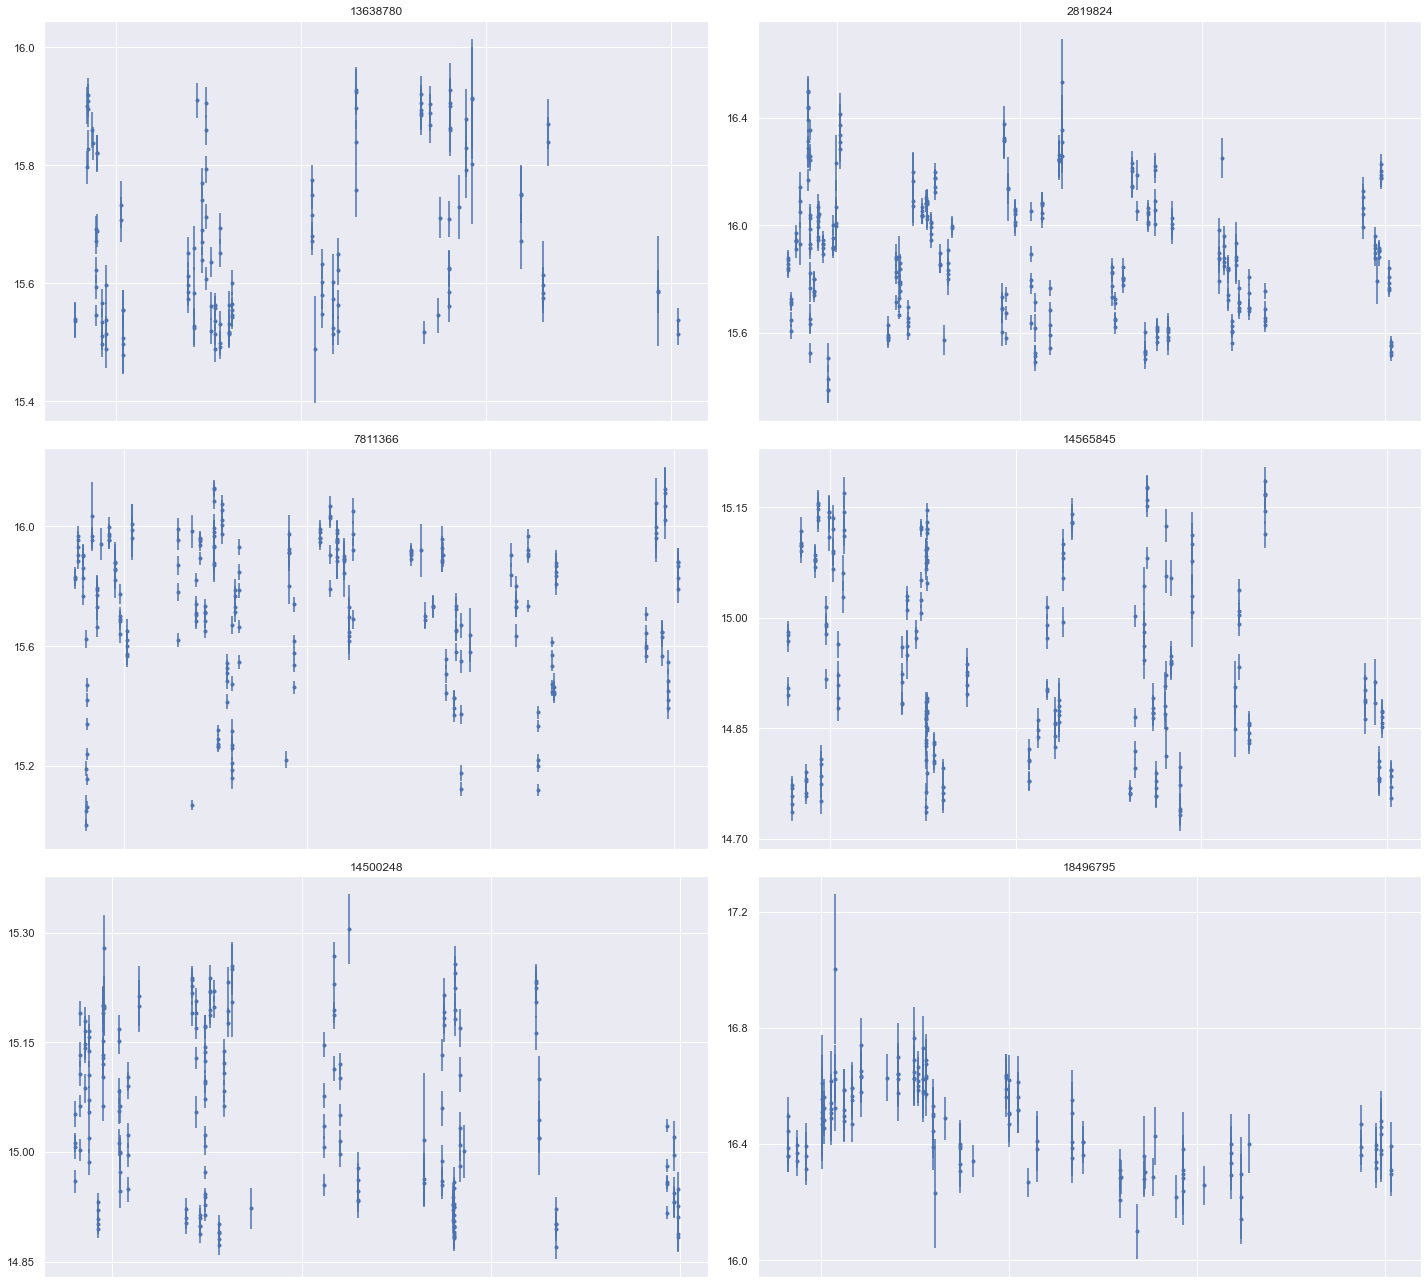

In [27]:
plotting_lc('LINEAR', 6, 3, 2)

Right now, the light curves do not amount to much, as they are not **phased**. After calculating the period, we can look deeper into the structure of the light curve and find out more about them. Now, onto the following dataset: ZTF.

# ZTF dataset

### A bit about ZTF

The `Zwicky Transient Facility` is an optical time-domain survey that uses the Palomar 48-inch Schmidt telescope to observe the entire Northern hemisphere sky in 3 different bands: `g,` `r`, and `i`, and has been operating since October 2017. This telescope has a large field of view, taking in a lot of data.

All the data gathered by `ZTF` is stored at the IPAC, which can be accessed via IRSA, as shown in this project. All of the raw data was processed so that every pixel had an average of 5 bits, and although this increased sky noise by 1%, the increase is negligible. All the images were FITS images which the program processed in the following way:
1. **Preprocessing:** removing bias frames and flat field correction frames.
2. **Astrometry:** Using the `SCAMP` package, all objects were astrometrically calibrated to match the `GAIA` survey.
3. **Photometry:** All images were photometrically calibrated following the `PanSTARRS 1` survey.
4. **Final processing:** Finally, masks were made for saturation, bad pixels were removed, ghosts and any instrumental artifacts, and other defects.

Every image was then categorized as either a moving or a changing source using the `ZOGY` algorithm. Furthermore, point-like moving objects were identified using the custom `ZTF Moving-object Discovery Engine (ZMODE).` 

`ZTF` was able to observe the following objects:
##### 1. Transient objects
These objects are supernovae found in other galaxies, and the `ZTF` survey captured their light curves.
##### 2. Neutrinos and gravitational-wave events
The `ZTF` survey showed that scientists could use `ZTF` in the future to undertake observations of neutrinos and gravitational-wave events. 
##### 3. Variable objects
These include variable stars but also light curves of asteroids. The light curves in the `ZTF`dataset were built upon every few months, and the light curves were stored in `HDF5` match files per each field of observation. `ZTF` contains many light curves, and some most notable types are *Be stars*, *RR Lyrae* stars, light curves of *NEOs*, *Asteroids*, and the activity of *Comets and Centaurs*.  

## Accessing ZTF data

Here, we use asynchronous querying for data, which dramatically speeds up computations depending on the number of CPU cores. The code for the function `lc_access` is in the Python file `ZTF_data.py`. All light curves are searched by equatorial coordinates and saved as data frames inside an array, along with the search ID.

In [28]:
ZTF_data = data_ztf()

Loading the data!


In [29]:
ZTF_data

array([[0,                mjd        mag    magerr
           0     58202.353634  16.516510  0.016864
           1     58202.357454  16.517498  0.016866
           2     58205.341262  16.568840  0.017013
           3     58205.392616  17.055435  0.019523
           4     58208.322326  16.585726  0.017066
           ...            ...        ...       ...
           2192  59272.303634  16.044613  0.014280
           2193  59272.304097  16.037762  0.014258
           2194  59324.245914  15.973496  0.014059
           2195  59324.246389  15.962948  0.014028
           2196  59325.292060  15.718016  0.013395

           [2197 rows x 3 columns]                ],
       [1,              mjd        mag    magerr
           0   58236.343900  17.252327  0.020999
           1   58236.344363  17.254246  0.021015
           2   58246.288773  17.166143  0.020332
           3   58246.289224  17.145496  0.020180
           4   58482.536204  17.296938  0.021367
           5   58507.492546  17.272144  

The ZTF data is structured so every light curve has an ID or the order it was processed in as the first element of a `tuple`, and the second element is a `Pandas DataFrame`, which contains the light curve data. 

In [30]:
nar = 0
na_id = []
for i in range(NUM_STARS):
    if ZTF_data[i][1].empty == True: # if the dataframe is empty,
        nar += 1 # count it
        na_id.append(i)
print(nar)
print(na_id)

178
[21, 43, 48, 64, 75, 119, 138, 151, 165, 180, 183, 200, 224, 233, 242, 270, 299, 303, 341, 360, 424, 428, 435, 509, 527, 619, 666, 667, 669, 671, 824, 840, 850, 889, 893, 901, 951, 954, 1001, 1006, 1015, 1047, 1095, 1141, 1169, 1183, 1193, 1198, 1300, 1314, 1319, 1321, 1397, 1461, 1481, 1518, 1582, 1624, 1626, 1629, 1633, 1637, 1648, 1702, 1931, 1932, 1936, 1942, 2034, 2046, 2094, 2131, 2244, 2257, 2422, 2429, 2472, 2487, 2527, 2615, 2697, 2741, 2744, 2765, 2891, 2969, 2987, 3067, 3086, 3099, 3175, 3298, 3324, 3518, 3523, 3597, 3692, 3755, 3799, 3831, 3850, 3895, 4052, 4100, 4139, 4206, 4216, 4303, 4323, 4329, 4371, 4399, 4400, 4401, 4408, 4410, 4422, 4425, 4528, 4643, 4671, 4682, 4749, 4763, 4764, 4825, 4872, 4919, 4923, 4984, 5002, 5008, 5045, 5054, 5069, 5123, 5132, 5210, 5246, 5297, 5298, 5308, 5320, 5346, 5356, 5373, 5389, 5390, 5409, 5794, 5852, 5924, 5940, 6106, 6408, 6411, 6414, 6450, 6481, 6497, 6501, 6551, 6559, 6589, 6609, 6620, 6638, 6681, 6685, 6814, 6857, 6895, 6962, 

We can see that 178 light curves in our ZTF dataset contain no values, meaning they were not found in the ZTF database. 

## Introductory information on ZTF light curves

Now that we have the data, we can look into some introductory information and take a look at the descriptive statistics and plots.

In [31]:
# counting the number of measurements of each light curve
pztf = []
for i in num:
    pztf.append(ZTF_data[i][1].shape[0])

In [32]:
total_obser_ztf = sum(pztf) # summing the number of observation for every light curve
print(total_obser_ztf)

9187878


So, our ZTF data contains 9 187 878 observations! That is almost nine times more than for the LINEAR data.

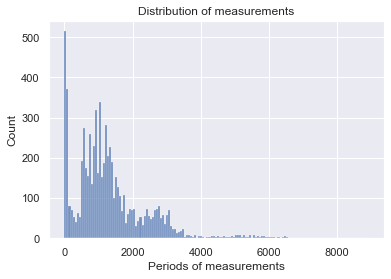

In [33]:
sns.histplot(data=pztf,bins=150)
plt.title('Distribution of measurements')
plt.xlabel('Periods of measurements')
plt.show()

The graph above shows that a considerable amount of light curves contain very few points in their observation, with another peak at around 1000 observations. 

In [34]:
# calculating the actuall time difference between the first and last observation.

tmztf = []
for i in num:
    if ZTF_data[i][1].shape[0] > 0:
        n = ZTF_data[i][1].shape[0]-1
        time = ZTF_data[i][1]['mjd'][n] - ZTF_data[i][1]['mjd'][0]
        tmztf.append(time)
    else:
        pass

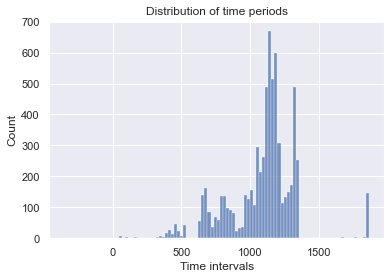

In [35]:
sns.histplot(data=tmztf,bins=100)
plt.title('Distribution of time periods')
plt.xlabel('Time intervals')
plt.show()

The graph above shows that most time intervals range between 1000 and 1300 days, meaning that the ZTF telescope observed each star shorter than the LINEAR telescope did. 

## Descriptive statistics of ZTF data

### ZTF Magnitude values

In [36]:
descriptive_stats_mag_ztf = lc_descriptive_stats_table_ZTF('mag')
descriptive_stats_mag_ztf

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
mag,16.178643,16.043728,0.490657,15.294890,17.274315,0.302372,-1.226580,1.979425
mag,16.918598,16.974806,0.276052,16.429140,17.351080,-0.171951,-1.230565,0.921940
mag,15.694814,15.453321,0.447303,15.009691,16.806747,0.278855,-1.236186,1.797056
mag,14.923299,14.997626,0.313663,13.541904,15.602118,-0.418363,-0.693641,2.060214
mag,14.282952,14.345203,0.320785,13.489013,15.489503,-0.321446,-0.732189,2.000490
...,...,...,...,...,...,...,...,...
mag,15.774477,15.781025,0.183799,15.362820,16.474918,0.084364,-0.954136,1.112099
mag,15.435583,15.416860,0.166361,14.992071,15.989974,0.565575,-0.432306,0.997903
mag,16.852069,16.859062,0.188836,16.465300,17.322569,0.138396,-0.644466,0.857269


In [50]:
descriptive_stats_mag_ztf.to_csv('../outputs/descriptive_mag_ZTF.csv', index=False)

### ZTF Error values

In [37]:
descriptive_stats_error_ztf = lc_descriptive_stats_table_ZTF('magerr')
descriptive_stats_error_ztf

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
magerr,0.015260,0.014701,0.001718,0.011990,0.021473,0.745989,0.134196,0.009483
magerr,0.018146,0.017816,0.002141,0.014859,0.021836,0.160915,-1.196048,0.006977
magerr,0.013846,0.013472,0.000893,0.012461,0.017227,0.480517,0.250568,0.004766
magerr,0.014148,0.014494,0.000804,0.011187,0.015498,-0.252004,-1.111077,0.004311
magerr,0.014164,0.014108,0.000228,0.012926,0.014828,-1.162798,8.044571,0.001902
...,...,...,...,...,...,...,...,...
magerr,0.018714,0.016886,0.002318,0.016669,0.022746,0.467789,-1.641290,0.006076
magerr,0.019261,0.017416,0.002537,0.016752,0.023453,0.440819,-1.648748,0.006701
magerr,0.017113,0.017134,0.001419,0.014446,0.020885,0.281310,-0.621198,0.006439


## Analysis of ZTF magnitude values

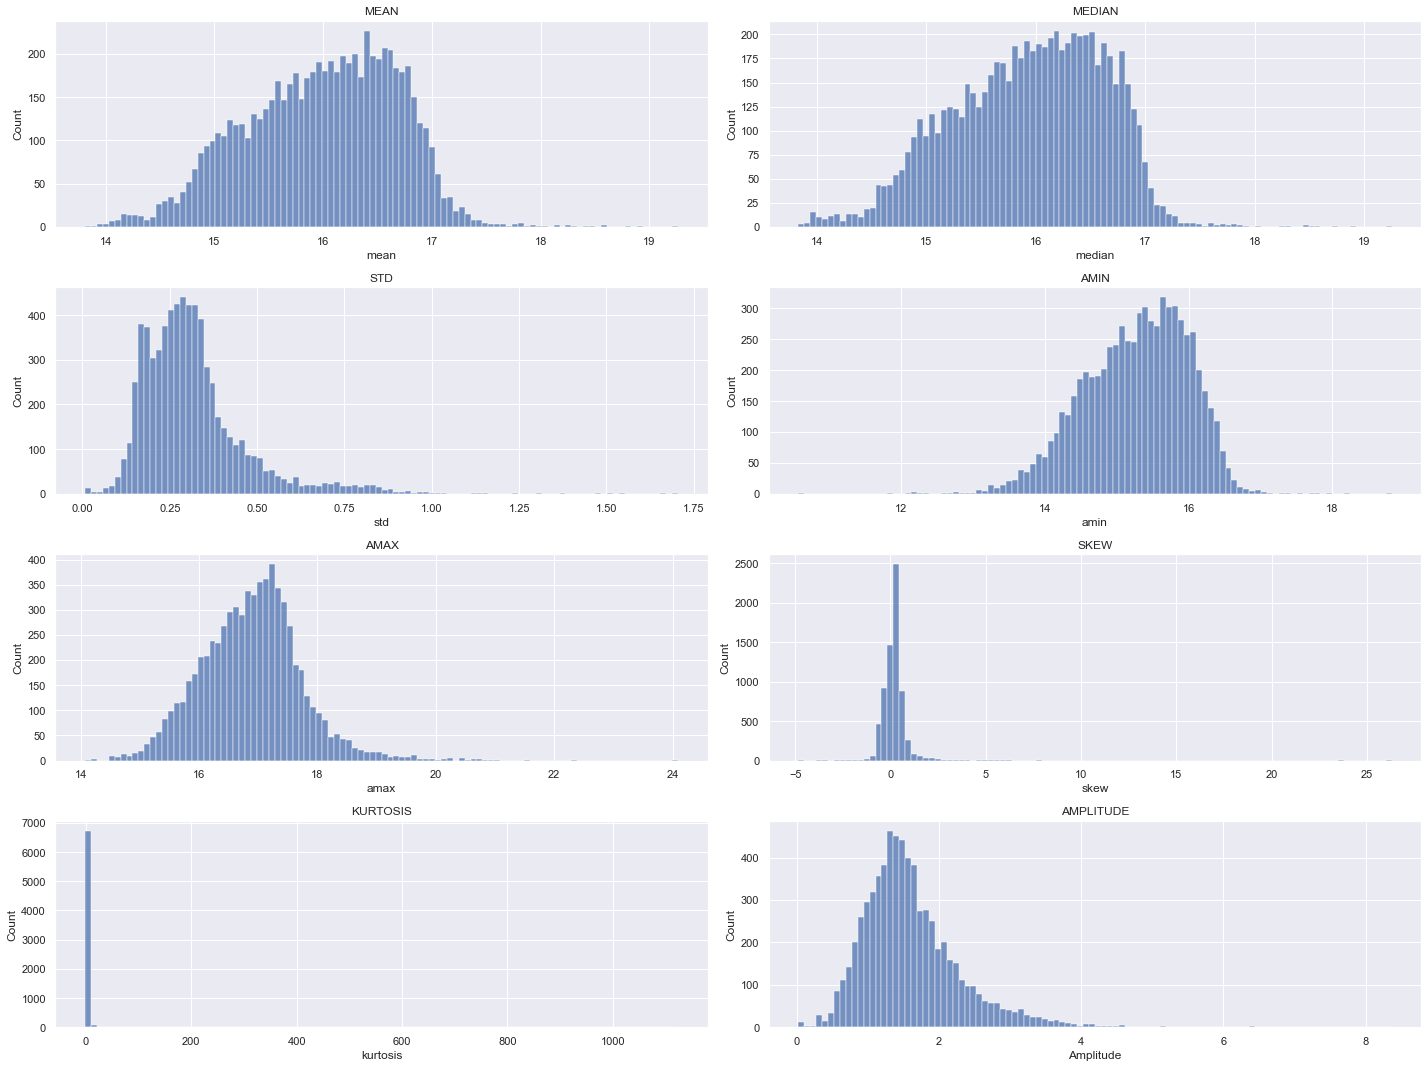

In [38]:
plotting_descriptive_stats(descriptive_stats_mag_ztf, 150)

From the graphs above, we can conclude a few things:
1. **Mean graph:** The most common mean ranges from 16 to 17 magnitudes, a higher average magnitude than in the `LINEAR` dataset.
2. **Median graph:** Here, the most common median ranges also from 16 to 17, and since both the average value and the median have a very similar distribution, a lot of our data is close to a normal distribution.
3. **Standard deviation graph:** Here, the graph is skewed towards the right, and most values range from around 0.1 to 0.35, which is highly similar to the `LINEAR` data, implying that the distribution of magnitudes hasn't changed much. 
4. **Min graph:** Here, we can see that the minimum ranges from 12 to 18 magnitudes are wider than in the `LINEAR` dataset. Most minimums are concentrated from around 15 to 16 magnitudes, the same as in the `LINEAR` dataset.
5. **Max graph:** The maximums range from 14 to 24, an extensive range, wider than in the `LINEAR` dataset. Most maximums are concentrated from around 16 to 18, a wider range than in the `LINEAR` dataset.
6. **Skew graph:** We can see that most light curves have a skewness of around 0, meaning they are centered around the mean and median. A tiny fraction of light curves have any other value but close to 0. The `LINEAR` dataset had a larger range of skewness, implying that the `ZTF` data is more centralized. 
7. **Kurtosis graph:** Here, we can see that almost all light curves have a kurtosis of 0, meaning they are distributed almost like a normal distribution. The `LINEAR` dataset has the same trait, albeit with a slightly larger range of kurtosis values.
8. **Amplitude graph:** Here, we can see that most light curves have a magnitude change from 1 to 2 magnitudes; there are examples with even eight magnitudes of change! This is a significantly higher range of values than the `LINEAR` dataset. 

### Plotting a few light curve distributions of ZTF data

In [39]:
listi_ztf = [ random.randint(0,7009) for i in range(6)] # creating a list of randomly selected ZTF ID's
listi_ztf

[3906, 3500, 1344, 1076, 2629, 5653]

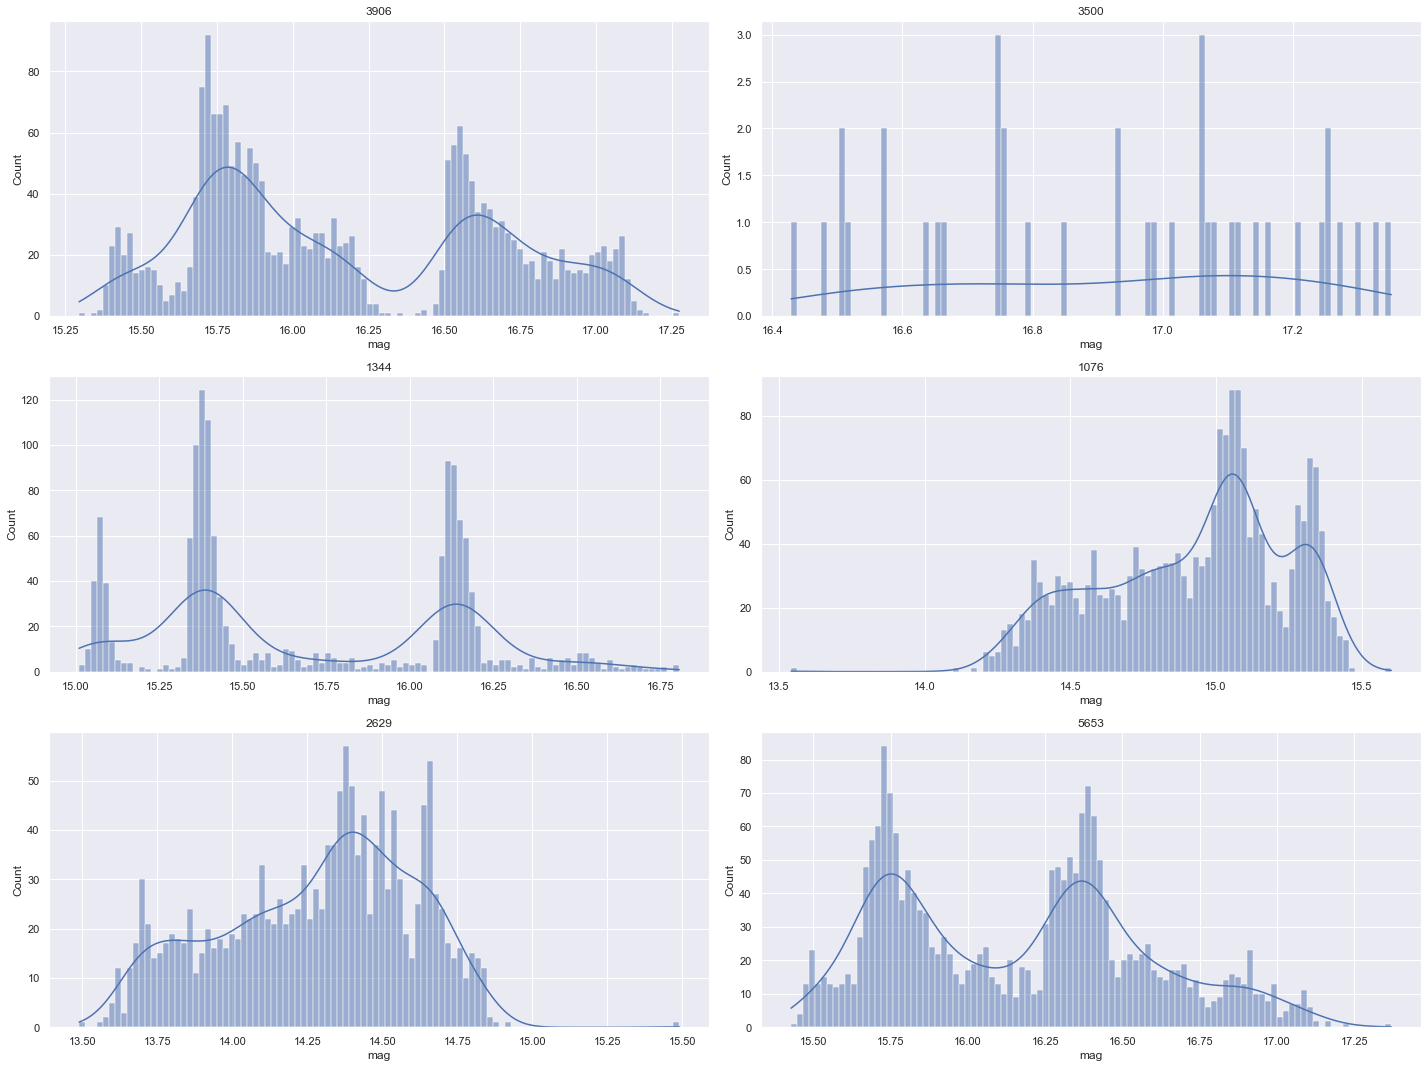

In [40]:
fig, ax = plt.subplots(3,2, figsize=(20,15)) 
ax = ax.flatten() 
for i in range(6): 
    lc = ZTF_data[i][1]['mag']
    ax[i].set_title(listi_ztf[i])
    sns.histplot(data=lc,bins=100,ax=ax[i], kde=True)
plt.tight_layout()
plt.show()

The graphs above show that some light curves have multiple peaks, some are unusual (light curve 6199), and that every light curve is unique.

### Correlations between ZTF parameters

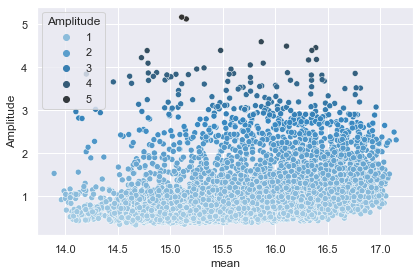

In [41]:
plotting_correlations(descriptive_stats_mag, 'mean', 'Amplitude', 'Amplitude', 'Blues_d')

The graph above shows no visible correlation between the mean and the amplitude.

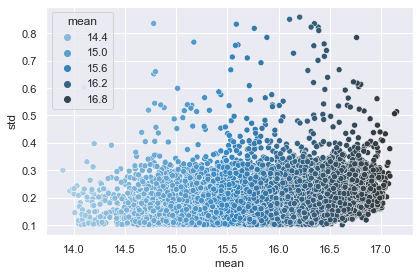

In [42]:
plotting_correlations(descriptive_stats_mag, 'mean', 'std', 'mean', 'Blues_d')

The graph above also shows no meaningful correlation between the mean and the standard deviation. 

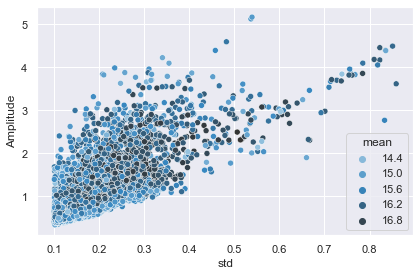

In [43]:
plotting_correlations(descriptive_stats_mag, 'std', 'Amplitude', 'mean', 'Blues_d')

However, the graph above shows an interesting correlation, just as in the `LINEAR` dataset. As the standard deviation increases that the amplitude also increases. The trend is especially accentuated after the standard deviation is over 1. The observation implies that more spread-out light curves have more significant magnitude changes. 

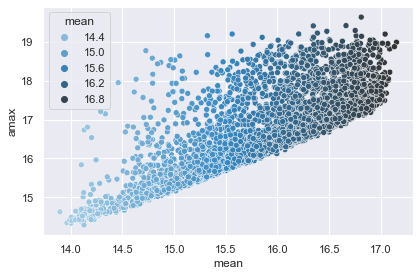

In [44]:
plotting_correlations(descriptive_stats_mag, 'mean', 'amax', 'mean', 'Blues_d')

As with the `LINEAR` dataset, the mean and max of magnitude values have a visible correlation.

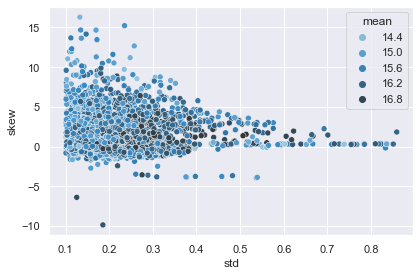

In [45]:
plotting_correlations(descriptive_stats_mag, 'std', 'skew', 'mean', 'Blues_d')

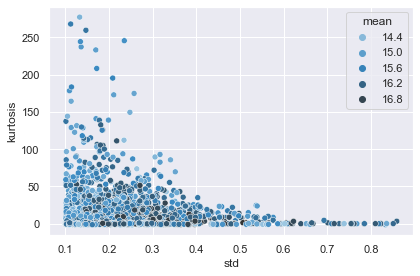

In [46]:
plotting_correlations(descriptive_stats_mag, 'std', 'kurtosis', 'mean', 'Blues_d')

The above two graphs show that no matter the spread of magnitude values, skew and kurtosis stay at approximately the same value. However, when the standard deviation is small, a fraction of light curves have more varied skewness and kurtosis. 

## Analysis of error values ZTF

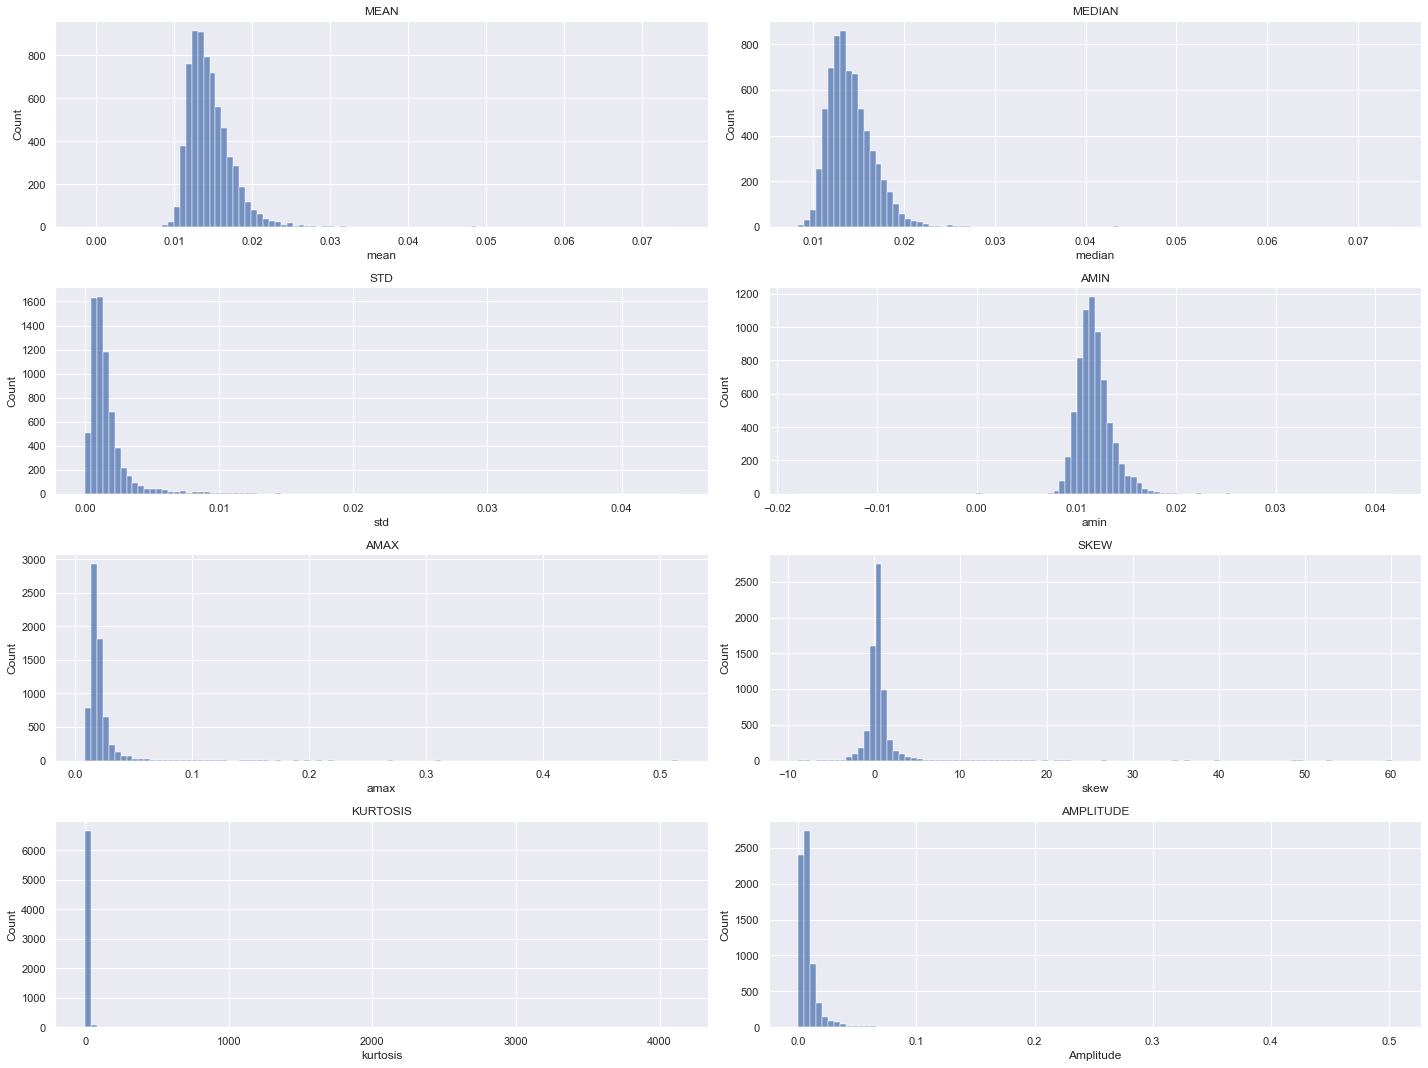

In [47]:
plotting_descriptive_stats(descriptive_stats_error_ztf, 150)

We can make a few conclusions based on the following observations:
1. **Mean graph:** Most average errors range from 0.01 to 0.02 magnitudes, slightly larger than from the `LINEAR` dataset.
2. **Median graph:** Most median errors range from 0.01 to 0.02 magnitudes. This range is much smaller and more centralized than in the `LINEAR` dataset. We also see that the median and mean are almost the same, meaning that the distribution of errors is centralized.
3. **Standard deviation graph:** Most values range from almost 0 to around 0.05, meaning the errors are highly concentrated in the center and not very spread out. It turns out that all of the graphs for the `ZTF` dataset are more concentrated than the `LINEAR` dataset.
4. **Minimum graph:** Most values range from 0.01 to 0.02, a minimal error. This range is smaller than for the `LINEAR` data.
5. **Maximum graph:** Most values range from almost 0 to 0.1. This is a tiny maximum error range. 
6. **Skewness graph:** Most values are around 0, meaning that the distribution of errors is very centralized. 
7. **Kurtosis graph:** Almost all values have a kurtosis of 0. This means that most light curves have a very similar shape to a standard distribution. 
8. **Amplitude graph:** Most error amplitudes are around 0 and reach about 0.1, a very small error range.

## Plotting examples of light curves ZTF

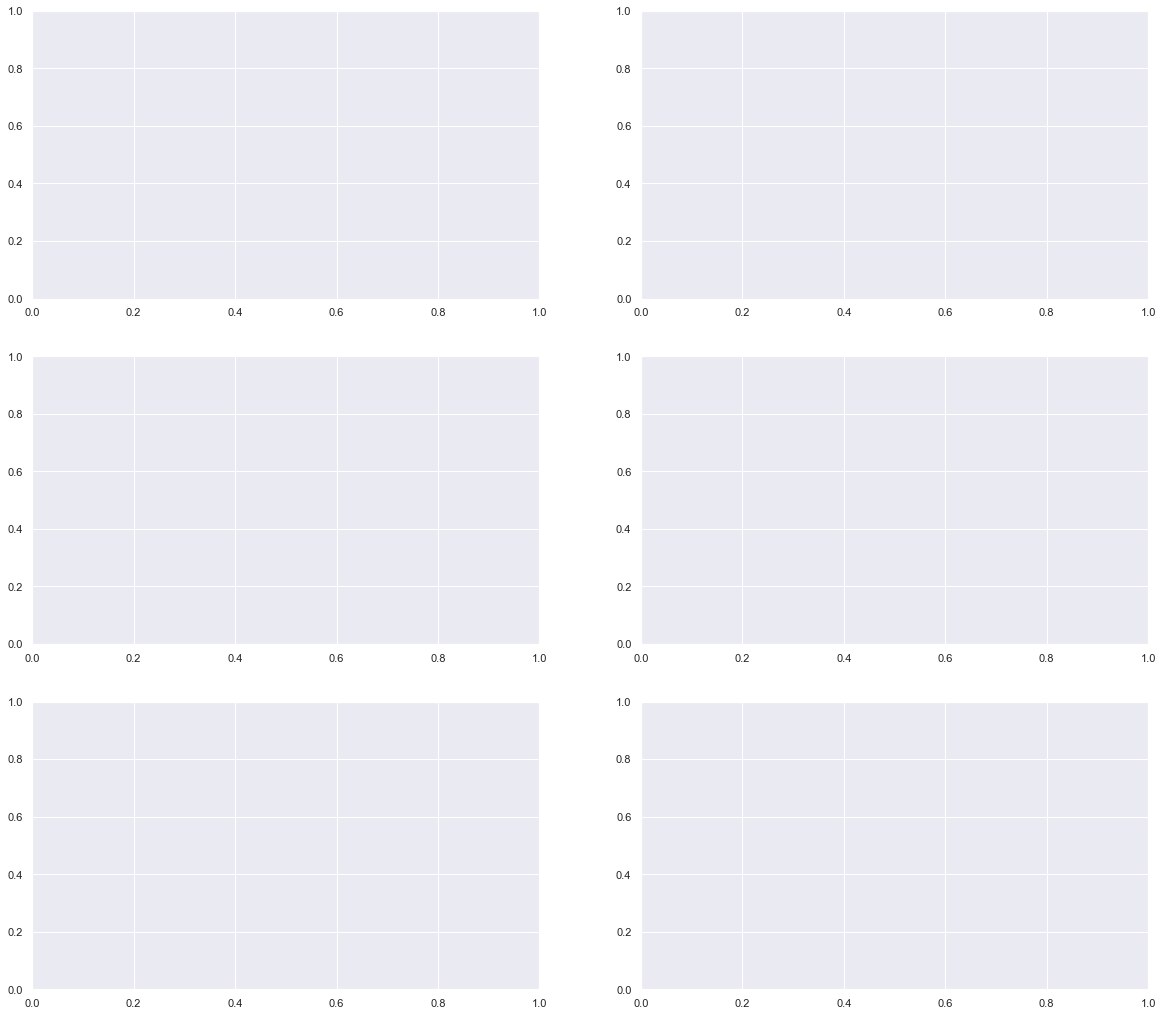

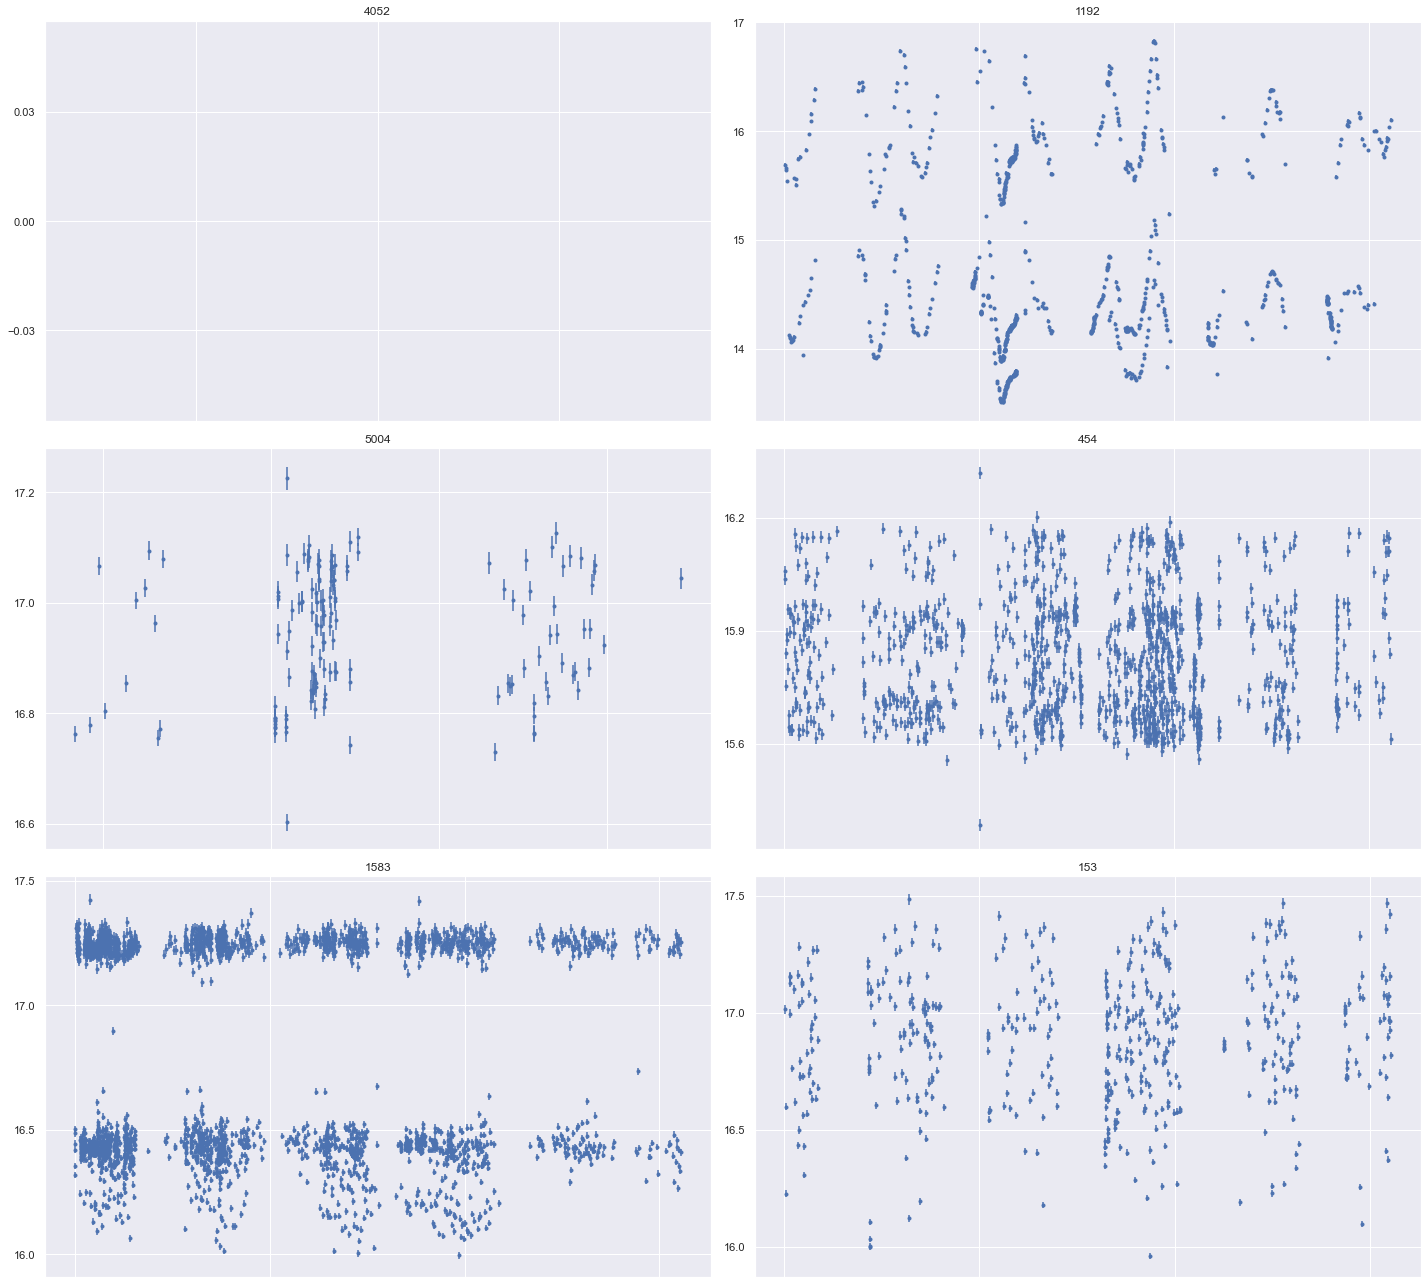

In [48]:
plotting_lc('ZTF', 6, 3, 2)

Now that we have a basic understanding of both `LINEAR` and `ZTF` data, we can continue analyzing the light curves themselves. We will analyze light curves in the following notebook by calculating their periods. 

*Ema Donev, 2023.*